# Modeling and Simulation in Python

Case Study: Predicting salmon returns

This case study is based on a ModSim student project by Josh Deng and Erika Lu.

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Can we predict salmon populations?

Each year the [U.S. Atlantic Salmon Assessment Committee](https://www.nefsc.noaa.gov/USASAC/Reports/USASAC2018-Report-30-2017-Activities.pdf) reports estimates of salmon populations in oceans and rivers in the northeastern United States.  The reports are useful for monitoring changes in these populations, but they generally do not include predictions.

The goal of this case study is to model year-to-year changes in population, evaluate how predictable these changes are, and estimate the probability that a particular population will increase or decrease in the next 10 years.

As an example, I'll use data from page 18 of the 2017 report, which provides population estimates for the Narraguagus and Sheepscot Rivers in Maine.

![USASAC_Report_2017_Page18](data/USASAC_Report_2017_Page18.png)

At the end of this notebook, I make some suggestions for extracting data from a PDF document automatically, but for this example I will keep it simple and type it in.

Here are the population estimates for the Narraguagus River:

In [2]:
pops = [2749, 2845, 4247, 1843, 2562, 1774, 1201, 1284, 1287, 2339, 1177, 962, 1176, 2149, 1404, 969, 1237, 1615, 1201];

To get this data into a Pandas Series, I'll also make a range of years to use as an index.

In [3]:
years = range(1997, 2016)

range(1997, 2016)

And here's the series.

In [45]:
pop_series = TimeSeries(pops, index=years)

,values
1997,2749
1998,2845
1999,4247
2000,1843
2001,2562
2002,1774
2003,1201
2004,1284
2005,1287
2006,2339


Here's what it looks like:

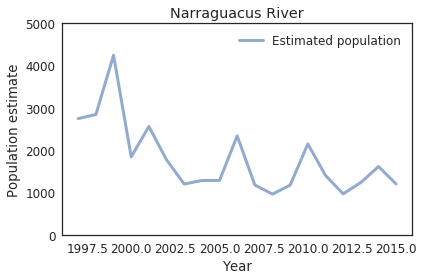

In [46]:
def plot_population(series):
    plot(series, label='Estimated population')
    decorate(xlabel='Year', 
             ylabel='Population estimate', 
             title='Narraguacus River',
             ylim=[0, 5000])
    
plot_population(pop_series)

## Modeling changes

To see how the population changes from year-to-year, I'll use `diff` to compute the absolute difference between each year and the next.

`shift` adjusts the result so each change aligns with the year it happened.

In [7]:
abs_diffs = pop_series.diff().shift(-1)

1997      96.0
1998    1402.0
1999   -2404.0
2000     719.0
2001    -788.0
2002    -573.0
2003      83.0
2004       3.0
2005    1052.0
2006   -1162.0
2007    -215.0
2008     214.0
2009     973.0
2010    -745.0
2011    -435.0
2012     268.0
2013     378.0
2014    -414.0
2015       NaN
dtype: float64

We can compute relative differences by dividing by the original series elementwise.

In [8]:
rel_diffs = abs_diffs / pop_series

1997    0.034922
1998    0.492794
1999   -0.566047
2000    0.390125
2001   -0.307572
2002   -0.322999
2003    0.069109
2004    0.002336
2005    0.817405
2006   -0.496794
2007   -0.182668
2008    0.222453
2009    0.827381
2010   -0.346673
2011   -0.309829
2012    0.276574
2013    0.305578
2014   -0.256347
2015         NaN
dtype: float64

These relative differences are observed annual net growth rates.  So let's drop the `NaN` and save them.

In [9]:
rates = rel_diffs.dropna()

1997    0.034922
1998    0.492794
1999   -0.566047
2000    0.390125
2001   -0.307572
2002   -0.322999
2003    0.069109
2004    0.002336
2005    0.817405
2006   -0.496794
2007   -0.182668
2008    0.222453
2009    0.827381
2010   -0.346673
2011   -0.309829
2012    0.276574
2013    0.305578
2014   -0.256347
dtype: float64

A simple way to model this system is to draw a random value from this series of observed rates each year.  We can use the NumPy function `choice` to make a random choice from a series.

In [10]:
np.random.choice(rates)

0.22245322245322247

## Simulation

Now we can simulate the system by drawing random growth rates from the series of observed rates.

I'll start the simulation in 2015.

In [11]:
t_0 = 2015
p_0 = pop_series[t_0]

1201

As usual, we'll put the parameters of the model into a `System` object.

The series of observed rates is one big parameter of the model.

In [12]:
system = System(t_0=t_0,
                p_0=p_0,
                duration=10,
                rates=rates)

,values
t_0,2015
p_0,1201
duration,10
rates,1997 0.034922 1998 0.492794 1999 -0.56...


Here's the update function.  It chooses a random growth rate, computes the change in population, and returns the new population.

In [13]:
def update_func1(pop, t, system):
    """Simulate one time step.
    
    pop: population
    t: time step
    system: System object
    """
    rate = np.random.choice(system.rates)
    pop += rate * pop
    return pop

Here's a version of `run_simulation` that stores the results in a `TimeSeries` and returns it.

In [14]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    t_0 = system.t_0
    t_end = t_0 + system.duration
    
    results = TimeSeries()
    results[t_0] = system.p_0
    
    for t in linrange(t_0, t_end-1):
        results[t+1] = update_func(results[t], t, system)

    return results

Here is the result of one run.  Each time you run this, you'll get different results.

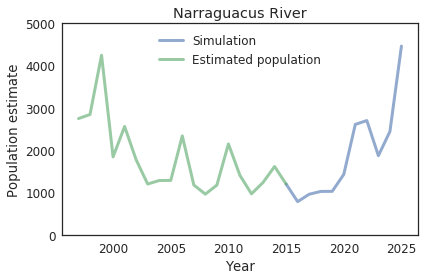

In [15]:
results = run_simulation(system, update_func1)
plot(results, label='Simulation')
plot_population(pop_series)

To get a sense of how much the results vary, we can run the model several times and plot all of the results.

In [16]:
def plot_many_simulations(system, update_func, iters):
    """Runs simulations and plots the results.
    
    system: System object
    update_func: function object
    iters: number of simulations to run
    """
    for i in range(iters):
        results = run_simulation(system, update_func)
        plot(results, color='gray', linewidth=5, alpha=0.1)

The plot option `alpha=0.1` makes the lines semi-transparent, so they are darker where they overlap.

Here are the results.

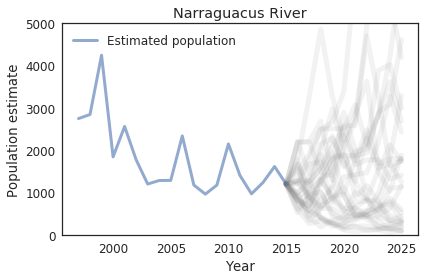

In [17]:
plot_many_simulations(system, update_func1, 30)
plot_population(pop_series)

The results are highly variable: according to this model, the population might continue to decline over the next 10 years, or it might recover and grow rapidly!

It's hard to say how seriously we should take this model.  There are many factors that influence salmon populations that are not included in the model.  For example, if the population starts to grow quickly, it might be limited by resource limits, predators, or fishing.  If the population starts to fall, humans might restrict fishing and stock the river with farmed fish.

So these results should probably not be considered useful predictions.  However, there might be something useful we can do, which is to estimate the probability that the population will increase or decrease in the next 10 years.  

## Distribution of net changes

The following function runs simulations and saves the final population from each run in a series:

In [18]:
def run_many_simulations(system, update_func, iters):
    """Runs simulations and report final populations.
    
    system: System object
    update_func: function object
    iters: number of simulations to run
    
    returns: series of final populations
    """
    
    last_pops = ModSimSeries()
    
    for i in range(iters):
        results = run_simulation(system, update_func)
        last_year = get_last_label(results)
        last_pops[i] = results[last_year]
        
    return last_pops

If we run a few simulations we can see that the results vary:

In [19]:
run_many_simulations(system, update_func1, 5)

,values
0,197.070395
1,390.718373
2,3920.040362
3,1323.759085
4,2971.527855


Now we can run 1000 simulations and describe the distribution of the results.

In [20]:
last_pops = run_many_simulations(system, update_func1, 1000)
last_pops.describe()

count     1000.000000
mean      1617.328083
std       2671.566824
min         18.388545
25%        298.418781
50%        717.135081
75%       1897.193595
max      33340.596263
dtype: float64

If we substract off the initial population, we get the distribution of changes.

In [21]:
net_changes = last_pops - p_0
net_changes.describe()

count     1000.000000
mean       416.328083
std       2671.566824
min      -1182.611455
25%       -902.581219
50%       -483.864919
75%        696.193595
max      32139.596263
dtype: float64

The mean is positive, but that's influenced by a few runs where the population gets unrealistically large.

The median is negative, which indicates that the population decreases more often than it increases.

We can be more specific by counting the number of runs where `net_changes` is positive.

In [22]:
np.sum(net_changes > 0)

353

Or we can use `mean` to compute the fraction of runs where `net_changes` is positive.

In [23]:
np.mean(net_changes > 0)

0.353

And here's the fraction where it's negative.

In [24]:
np.mean(net_changes < 0)

0.647

So, based on observed past changes, this model predicts that the population is more likely to decrease than increase over the next 10 years, by about 2:1.

## A refined model

There are a few ways we could improve the model.

1.  It looks like there might be cyclic behavior in the past data, with a period of 4-5 years.  We could extend the model to include this effect.

2.  Older data might not be as relevant for prediction as newer data, so we could give more weight to newer data.

The second option is easier to implement, so let's try it.

I'll use `linspace` to create an array of "weights" for the observed rates.  The probability that I choose each rate will be proportional to these weights.

The weights have to add up to 1, so I divide through by the total.

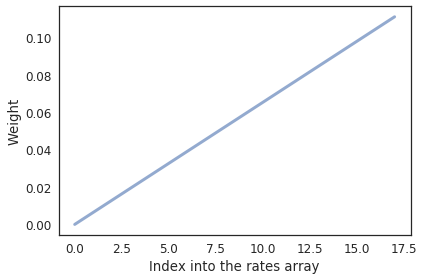

In [25]:
weights = linspace(0, 1, len(rates))
weights /= sum(weights)
plot(weights)
decorate(xlabel='Index into the rates array',
         ylabel='Weight')

I'll add the weights to the `System` object, since they are parameters of the model.

In [26]:
system.weights = weights

Here's a version of the update function that uses the weights by passing them to `np.random.choice` (see the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html))

In [27]:
def update_func2(pop, t, system):
    """Simulate one time step.
    
    pop: population
    t: time step
    system: System object
    """
    rate = np.random.choice(system.rates, p=system.weights)
    pop += rate * pop
    return pop

The results are not obviously different from what we saw before.

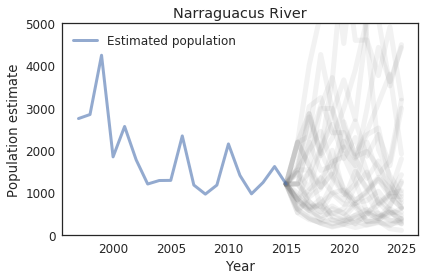

In [28]:
plot_many_simulations(system, update_func2, 30)
plot_population(pop_series)

The distribution of net changes is similar.

In [29]:
last_pops = run_many_simulations(system, update_func2, 1000)
net_changes = last_pops - p_0
net_changes.describe()

count     1000.000000
mean       704.234022
std       3297.810927
min      -1171.461435
25%       -834.175467
50%       -372.285503
75%        843.975798
max      28349.380320
dtype: float64

And the probability that the population will decline is about the same.

In [30]:
np.mean(net_changes < 0)

0.619

I conclude that extending the model to give more weight to recent data does not have much effect on the model.

This suggests that the simpler assumption -- that all observed changes are equally relevant -- is not a major source of error.

## Extracting data from a PDF document

The following section uses PyPDF2 to get data from a PDF document.  It uses features we have not seen yet, so don't worry if it doesn't all make sense.

The PyPDF2 package provides functions to read PDF documents and get the data.

If you don't already have it installed, and you are using Anaconda, you can install it by uncommenting and running the following cell (keep the exclamation point).

In [31]:
#  !conda install -c conda-forge pypdf2

In [32]:
import PyPDF2

The 2017 report is in the data directory.

In [33]:
pdfFileObj = open('data/USASAC2018-Report-30-2017-Activities-Page11.pdf', 'rb')

<_io.BufferedReader name='data/USASAC2018-Report-30-2017-Activities-Page11.pdf'>

The `PdfFileReader` object knows how to read PDF documents.

In [34]:
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

This file contains only one page.

In [35]:
pdfReader.numPages

1

`getPage` selects the only page in the document.

In [36]:
page = pdfReader.getPage(0)
page.extractText()

'USASAC ANNUAL REPORT 2017/30\n11 \nTable 1.3.2 Estimated Atlantic salmon returns to the USA, 1997-2017. "Natural" includes fish originating \nfrom natural spawning, hatchery fry stocking, or hatchery egg planting Starting in 2003 estimated returns \nalso include returns estimated adult returns from redd counts. \nYear \nSea age \n  \nOrigin \n1 SW \n2SW \n3SW \nRepeat \nTotal\n  \nHatchery \nNatural \n1997 \n278 \n1,492 \n8 \n36 \n1,814 \n  \n1,296 \n518 \n1998 \n340 \n1,477 \n3 \n42 \n1,862 \n  \n1,146 \n716 \n1999 \n402 \n1,136 \n3 \n26 \n1,567 \n  \n959\n608 \n2000 \n292 \n535 \n0 \n20 \n847 \n  \n562\n285 \n2001 \n269 \n804 \n7 \n4 \n1,084 \n  \n833\n251 \n2002 \n437 \n505 \n2 \n23 \n967 \n  \n832\n135 \n2003 \n233 \n1,185 \n3 \n6 \n1,427 \n  \n1,238 \n189 \n2004 \n319 \n1,266 \n21 \n24 \n1,630 \n  \n1,395 \n235 \n2005 \n317 \n945 \n0 \n10 \n1,272 \n  \n1,019 \n253 \n2006 \n442 \n1,007 \n2 \n5 \n1,456 \n  \n1,167 \n289 \n2007 \n299 \n958 \n3 \n1 \n1,261 \n  \n940\n321 \n2008 \n812

The following function iterates through the lines on the page, removes whitespace, and ignores lines that contain only whitespace.

In [37]:
def iter_page(page):
    for item in page.extractText().splitlines():
        item = item.strip()
        if item:
            yield item

The following function gets the next `n` pages from the page.

In [38]:
def next_n(iterable, n):
    """Get the next n items from an iterable."""
    return [next(iterable) for i in range(n)]

We skip the text at the top of the page.

In [39]:
t = iter_page(page)
discard = next_n(t, 8)

['USASAC ANNUAL REPORT 2017/30',
 '11',
 'Table 1.3.2 Estimated Atlantic salmon returns to the USA, 1997-2017. "Natural" includes fish originating',
 'from natural spawning, hatchery fry stocking, or hatchery egg planting Starting in 2003 estimated returns',
 'also include returns estimated adult returns from redd counts.',
 'Year',
 'Sea age',
 'Origin']

The next 7 strings are the column headings of the table.

In [40]:
columns = next_n(t, 7)

['1 SW', '2SW', '3SW', 'Repeat', 'Total', 'Hatchery', 'Natural']

Create an empty `Dataframe` with the column headings.

In [41]:
df = pd.DataFrame(columns=columns)
df

,1 SW,2SW,3SW,Repeat,Total,Hatchery,Natural


Get the next 19 lines of the table.

In [42]:
for i in range(19):
    year = int(next(t))
    data = next_n(t, 7)
    df.loc[year] = data

The last line in the table gets messed up, so I'll do that one by hand.

In [43]:
df.loc[2017] = ['363', '663', '13', '2', '1041', '806', '235'] 

Here's the result.

In [44]:
df

,1 SW,2SW,3SW,Repeat,Total,Hatchery,Natural
1997,278,"1,492",8,36,"1,814","1,296",518
1998,340,"1,477",3,42,"1,862","1,146",716
1999,402,"1,136",3,26,"1,567",959,608
2000,292,535,0,20,847,562,285
2001,269,804,7,4,"1,084",833,251
2002,437,505,2,23,967,832,135
2003,233,"1,185",3,6,"1,427","1,238",189
2004,319,"1,266",21,24,"1,630","1,395",235
2005,317,945,0,10,"1,272","1,019",253
2006,442,"1,007",2,5,"1,456","1,167",289


In general, reading tables from PDF documents is fragile and error-prone.  Sometimes it is easier to just type it in.